# Week 6: Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.

In [1]:
import sframe

In [2]:
products = sframe.SFrame('amazon_baby.gl/')

[INFO] SFrame v1.8.3 started. Logging /tmp/sframe_server_1458635359.log


# Remove punctuation

In [9]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)

# Extract sentiments

In [10]:
products = products[products['rating'] != 3]
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

# Split data

In [11]:
train_data, test_data = products.random_split(.8, seed=1)

# Build the word count vector for each review

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

# Train a classifier

In [13]:
from sklearn import linear_model

In [14]:
model = linear_model.LogisticRegression()

In [15]:
model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Model evaluation

* Accuracy

In [16]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].to_numpy(), y_pred=model.predict(test_matrix))
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.932445404368


* Baseline: majority class prediction

In [17]:
baseline = len(test_data[test_data['sentiment'] == 1])/float(len(test_data))
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


In [18]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3790
     -1       |        1        |  1451
      1       |       -1        |   801
      1       |        1        | 27294


In [19]:
print 'false positive:', 1451

false positive: 1451


* Computing the cost of mistakes

In [20]:
cost = 1451*100 + 801*1
print cost

145901


* Preision and recall

In [21]:
# precision
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
print "Precision on test data: %s" % precision

Precision on test data: 0.94952165594


In [22]:
# recall
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=model.predict(test_matrix))
print "Recall on test data: %s" % recall

Recall on test data: 0.971489588895


In [23]:
# recall for majority class 
float(801+27294)/(3790+1451+801+27294)

0.8427825773938085

# Precision-recall tradeoff

In [1]:
def apply_threhold(probabilities, threshold):
    results = (probabilities > threshold)
    results = results.apply(lambda x : 1 if x==1 else -1)
    return results

In [2]:
model.classes_

NameError: name 'model' is not defined

In [113]:
probabilities = model.predict_proba(test_matrix)[:, 1]
#probabilities = model.decision_function(test_matrix)

In [114]:
min(abs(probabilities))

8.8061679452029051e-16

In [115]:
apply_threhold(probabilities, 0.5).sum()

28745

In [116]:
apply_threhold(probabilities, 0.9).sum()

25073

In [117]:
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=apply_threhold(probabilities, 0.9))
print "Precision on test data: %s" % precision

# recall
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=apply_threhold(probabilities, 0.9))
print "Recall on test data: %s" % recall


Precision on test data: 0.981573804491
Recall on test data: 0.875992169425


# Precision-recall curve

In [118]:
threshold_values = np.linspace(0.5, 1, num=100)
#print threshold_values

In [119]:
precision_all = []
recall_all = []

for thr in threshold_values:
    precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                                y_pred=apply_threhold(probabilities, thr))

    recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                          y_pred=apply_threhold(probabilities, thr))
    
    precision_all.append(precision)
    recall_all.append(recall)

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

In [121]:
threshold_values[41]

0.70707070707070707

In [124]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        #y_pred=model.predict(test_matrix),
                        y_pred=apply_threhold(probabilities, 0.98),
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |     0
     -1       |        1        |   192
      1       |       -1        |     0
      1       |        1        | 19858


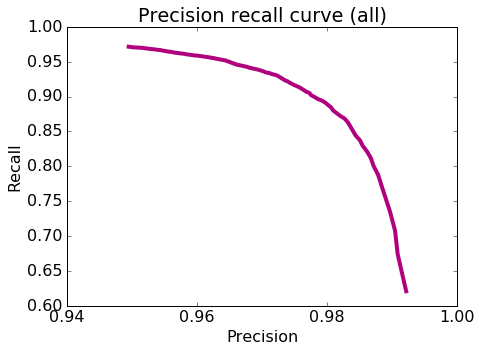

In [77]:
#plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')
plot_pr_curve(precision_all[:-2], recall_all[:-2], 'Precision recall curve (all)')

# Precision-recall on all baby related items

In [107]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [108]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
#probabilities = model.decision_function(baby_matrix)
probabilities = model.predict_proba(baby_matrix)[:, 1]

In [109]:
precision_all = []
recall_all = []

for thr in threshold_values:
    precision = precision_score(y_true=baby_reviews['sentiment'].to_numpy(), 
                                y_pred=apply_threhold(probabilities, thr))

    recall = recall_score(y_true=baby_reviews['sentiment'].to_numpy(),
                          y_pred=apply_threhold(probabilities, thr))
    
    precision_all.append(precision)
    recall_all.append(recall)

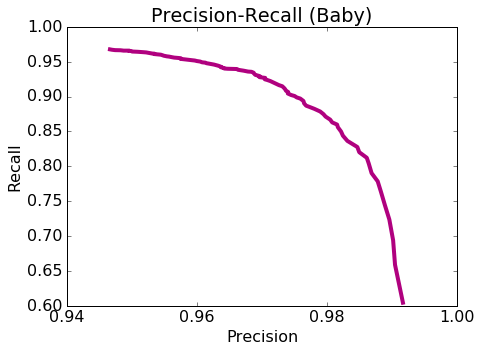

In [110]:
plot_pr_curve(precision_all[:-2], recall_all[:-2], "Precision-Recall (Baby)")

In [111]:
for i, pre in enumerate(precision_all):
    if pre > 0.965:
        print i, pre

46 0.96616189942
47 0.966304754773
48 0.967166979362
49 0.967851099831
50 0.968385397064
51 0.968708765316
52 0.968832640725
53 0.968974650019
54 0.969650986343
55 0.969604863222
56 0.97049305159
57 0.970431133155
58 0.970773638968
59 0.971280873061
60 0.972602739726
61 0.973119319281
62 0.973418703919
63 0.973561430793
64 0.97368933931
65 0.9740234375
66 0.973962411903
67 0.974474769291
68 0.975009838646
69 0.975340303807
70 0.975875024718
71 0.976365441907
72 0.976470588235
73 0.976776776777
74 0.977496483826
75 0.978037477332
76 0.978934575653
77 0.97944229595
78 0.979762878168
79 0.98046875
80 0.980785123967
81 0.981531438058
82 0.981655201167
83 0.982142857143
84 0.982433862434
85 0.98311965812
86 0.98464532872
87 0.984937786509
88 0.986095784595
89 0.986396074933
90 0.986833144154
91 0.987773933103
92 0.98824635637
93 0.988886204397
94 0.989560029828
95 0.990142671855
96 0.990434544958
97 0.991649269311
98 0.991646362687


In [112]:
threshold_values[46]

0.73232323232323238